In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from seaborn import heatmap
from sklearn.decomposition import PCA # Principal Component Analysis
from numpy.linalg import norm
from numpy import dot 
from statsmodels.tsa.stattools import (
    adfuller, 
    kpss, 
    ) # Homoscedasticity 



pd.set_option('display.max_columns', 40)
plt.rcParams.update({'axes.grid': True, 'grid.alpha': .33})


df: pd.DataFrame = pd.read_csv("Life Expectancy Data.csv")


# Format DataFrame for further analysis
stripped_columns = []

for col_num, col_name in enumerate(df.columns):
    stripped_columns.append(col_name.strip(' '))
    
df.columns = stripped_columns

# Failsafe DataFrame in case we duck up something
df = df.sort_values(by=['Country', 'Year'])
df = df.reset_index(drop=True)


# Dictionary with countries as keys and corresponding DataFrame slices as values
df_per_country = {country: df for country, df in df.groupby('Country')}

In [132]:
count = 0
for row_num, row in df.iterrows():
    if row.isnull().sum() > 0:
        count+=1


print(f"The proportion of rows with at least one missing value {count/len(df):.2f}")

The proportion of rows with at least one missing value 0.44


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

**<h4>**Handling outliers**<h4>**

In [134]:
# Replace values beyond IQR with median
for country, country_df in df_per_country.items():
    for column in country_df.columns[4:]:

        descriptive_stats = country_df[column].describe()


        median = descriptive_stats['50%']
        Q1 = descriptive_stats['25%']
        Q3 = descriptive_stats['75%']
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        upper_condition = (country_df[column] > upper_bound)
        lower_condition = (country_df[column] < lower_bound)

        combined_boolean_indexing = (upper_condition | lower_condition)
        
        country_df.loc[combined_boolean_indexing, column] = median

        


C:\Users\user\AppData\Local\Temp\ipykernel_28544\1032146720.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '111.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  country_df.loc[combined_boolean_indexing, column] = median
C:\Users\user\AppData\Local\Temp\ipykernel_28544\1032146720.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  country_df.loc[combined_boolean_indexing, column] = median
C:\Users\user\AppData\Local\Temp\ipykernel_28544\1032146720.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '109.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  country_

In [135]:
# Restoring DataFrame to its original shape
df = pd.concat(df_per_country.values())

**<h4>**But before we start handling missing data, let us standardize our data for later suggested algorithm**</h4>**


In [ ]:
# Standardize each column 
for column in df.columns[3:]:
    df[column] = (df[column] - df[column].mean())/df[column].std()


**<h2>**Handling missing data**</h2>**
**<h4>**For every column that contains NULL values we look for the indexes of missing values in order to understand the nature of the absence**<h4>**

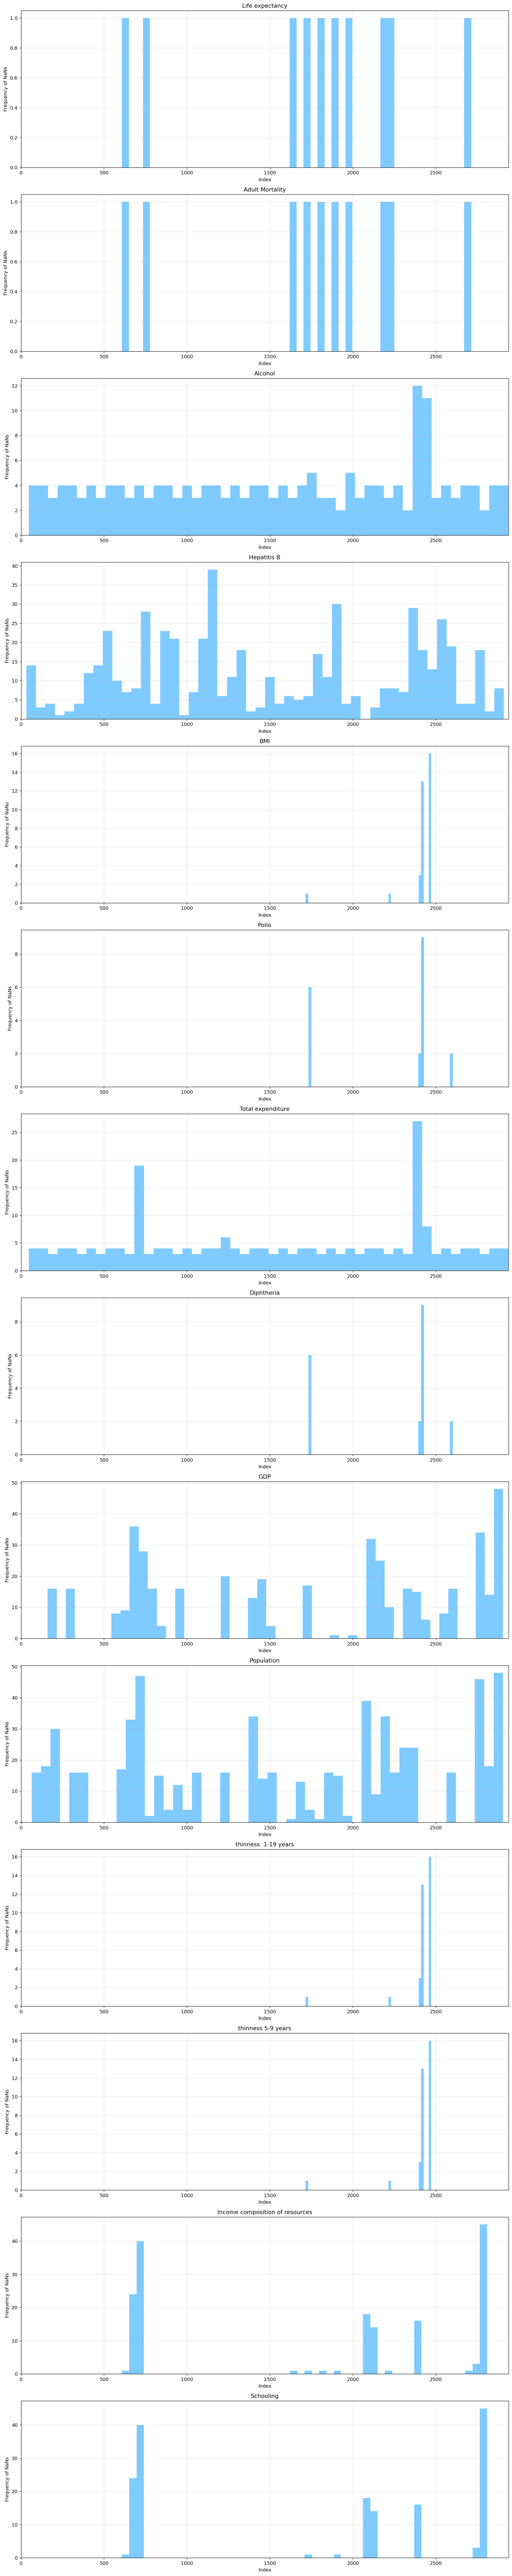

In [148]:
columns_with_null_values = df.columns[(df.isnull().sum() > 0).values]
column_and_indeces = {}

for column in columns_with_null_values:
    column_and_indeces[column] = df[df[column].isnull()].index

fig, axes = plt.subplots(len(column_and_indeces), figsize=(15, 75), dpi=130)
xmin = 0
xmax = len(df)

for index, (key, values) in enumerate(column_and_indeces.items()):
    axes[index].hist(values, bins=50, color=(0, 0.6, 1), alpha=0.5)
    
    axes[index].set_xlim(xmin, xmax)
    axes[index].set_title(key)
    axes[index].set_xlabel('Index')
    axes[index].set_ylabel('Frequency of NaNs')

plt.tight_layout()
plt.show()

**<h4>**We can see that for certain columns the reason behind missing data is not completely random (Alcohol, BMI, Diphteria and so on.)**</h4>**

**<h5>**This is not good, because we cannot really drop rows with null values as we're going to lose insane amount of data, and standard techniques such as filling Null values with median/mean of corresponding column will not be quite statistically accurate**</h5>**

**<h5>**Thus, I tried impementing another way of handling missing data**</h5>**
<br><br>
**<h3>**That's an experimental method to fill in NA values so I don't really count on its theorethical foundation**<h3>**

In [162]:
# Define cosine similarity function
def cosine_similarity(
        a: tuple | list,
        b: tuple | list
        ) -> np.float64:

    if norm(a) == 0.0 or norm(b) == 0.0 or np.isnan(norm(a)) or np.isnan(norm(b)):
        return 0.0
    
    return dot(a,b) / (norm(a) * norm(b))


# Leaving only rows with NULL values in DataFrame 
non_null_indexes = df.dropna().index
null_indexes = []

for index in df.index:
    if index not in non_null_indexes:
        null_indexes.append(index)


# DataFrame without null values
df_wo_null_values = df.copy()
df_wo_null_values = df_wo_null_values.dropna()
df_wo_null_values = df_wo_null_values.reset_index(drop=True)

# DataFrame with null values
df_with_null_values = df.copy()
df_with_null_values = df_with_null_values.iloc[null_indexes, :]
df_with_null_values = df_with_null_values.reset_index(drop=True)

for row_num, row in df_with_null_values.iterrows():

    columns_with_null_values = row[row.isnull()].index

    feature_vector = tuple(row.fillna(0).values)[3:]

    similarities = []

    for row_num_2, row_2 in df_wo_null_values.iterrows():

        feature_vector_2 = row_2.copy()
        feature_vector_2[columns_with_null_values] = 0
        feature_vector_2 = tuple(feature_vector_2.values)[3:]

        similarity = cosine_similarity(feature_vector, feature_vector_2)

        row_similarity = {row_num_2: similarity}
        similarities.append(row_similarity)
    

    
    series = pd.Series(similarities).apply(lambda x: list(x.values())[0])
    most_similar_rows = series.sort_values(ascending=False)[:100]
    most_similar_rows_indexes = most_similar_rows.index

    median_values = df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values].median()
    mad = (df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values] - df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values].mean()).abs().mean() 
    normally_distributed_value = np.random.normal(loc=0, scale=1, size=1)[0]

    values_to_fill = median_values + mad * normally_distributed_value
    df_with_null_values.loc[row_num, columns_with_null_values] = values_to_fill

In [163]:
# Save result as it takes way too much to run the algorithm above
df = pd.concat([df_wo_null_values, df_with_null_values]).reset_index(drop=True).sort_values(by=['Country', 'Year'])
df.to_csv('restored_df.csv')

In [165]:
cleaned_df = pd.read_csv('restored_df.csv')
cleaned_df = cleaned_df.drop('Unnamed: 0', axis=1)

**<h3>**Let's redo the procedure of handling outliers**<h3>**

In [166]:
df_per_country = {country: df for country, df in cleaned_df.groupby('Country')}

# Replace values beyond IQR with median
for country, country_df in df_per_country.items():
    for column in country_df.columns[4:]:

        descriptive_stats = country_df[column].describe()


        median = descriptive_stats['50%']
        Q1 = descriptive_stats['25%']
        Q3 = descriptive_stats['75%']
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        upper_condition = (country_df[column] > upper_bound)
        lower_condition = (country_df[column] < lower_bound)

        combined_boolean_indexing = (upper_condition | lower_condition)
        
        country_df.loc[combined_boolean_indexing, column] = median

        
# Restoring DataFrame to its original shape
cleaned_df = pd.concat(df_per_country.values())

**<h3>**Now as we have cleaned DataFrame without significat outliers, we can break this task into 2:**</h3>**

**<h4>**1) Regression Analysis for each year<br>2) Time Series Analysis for each country**</h4>**


**<h5>**NOTE: We can justify looking at the problem from regression point of view analysis the bare minimum condition of having atleast 5-6 training example per feature is satisfied**</h5>**


In [168]:
regression_df = cleaned_df.copy()
regression_df = regression_df.sort_values(by='Year')
regression_df = regression_df.reset_index(drop=True)

regression_df['Status'] = regression_df['Status'].replace({
    "Developed": 1,
    "Developing": 0,
})


C:\Users\user\AppData\Local\Temp\ipykernel_28544\991126393.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  regression_df['Status'] = regression_df['Status'].replace({


**<h3>**Let us investigate the feature space on correlations in order to have our model build on a correct dataset that will not result in statistically insignificant results**</h3>**

<Axes: >

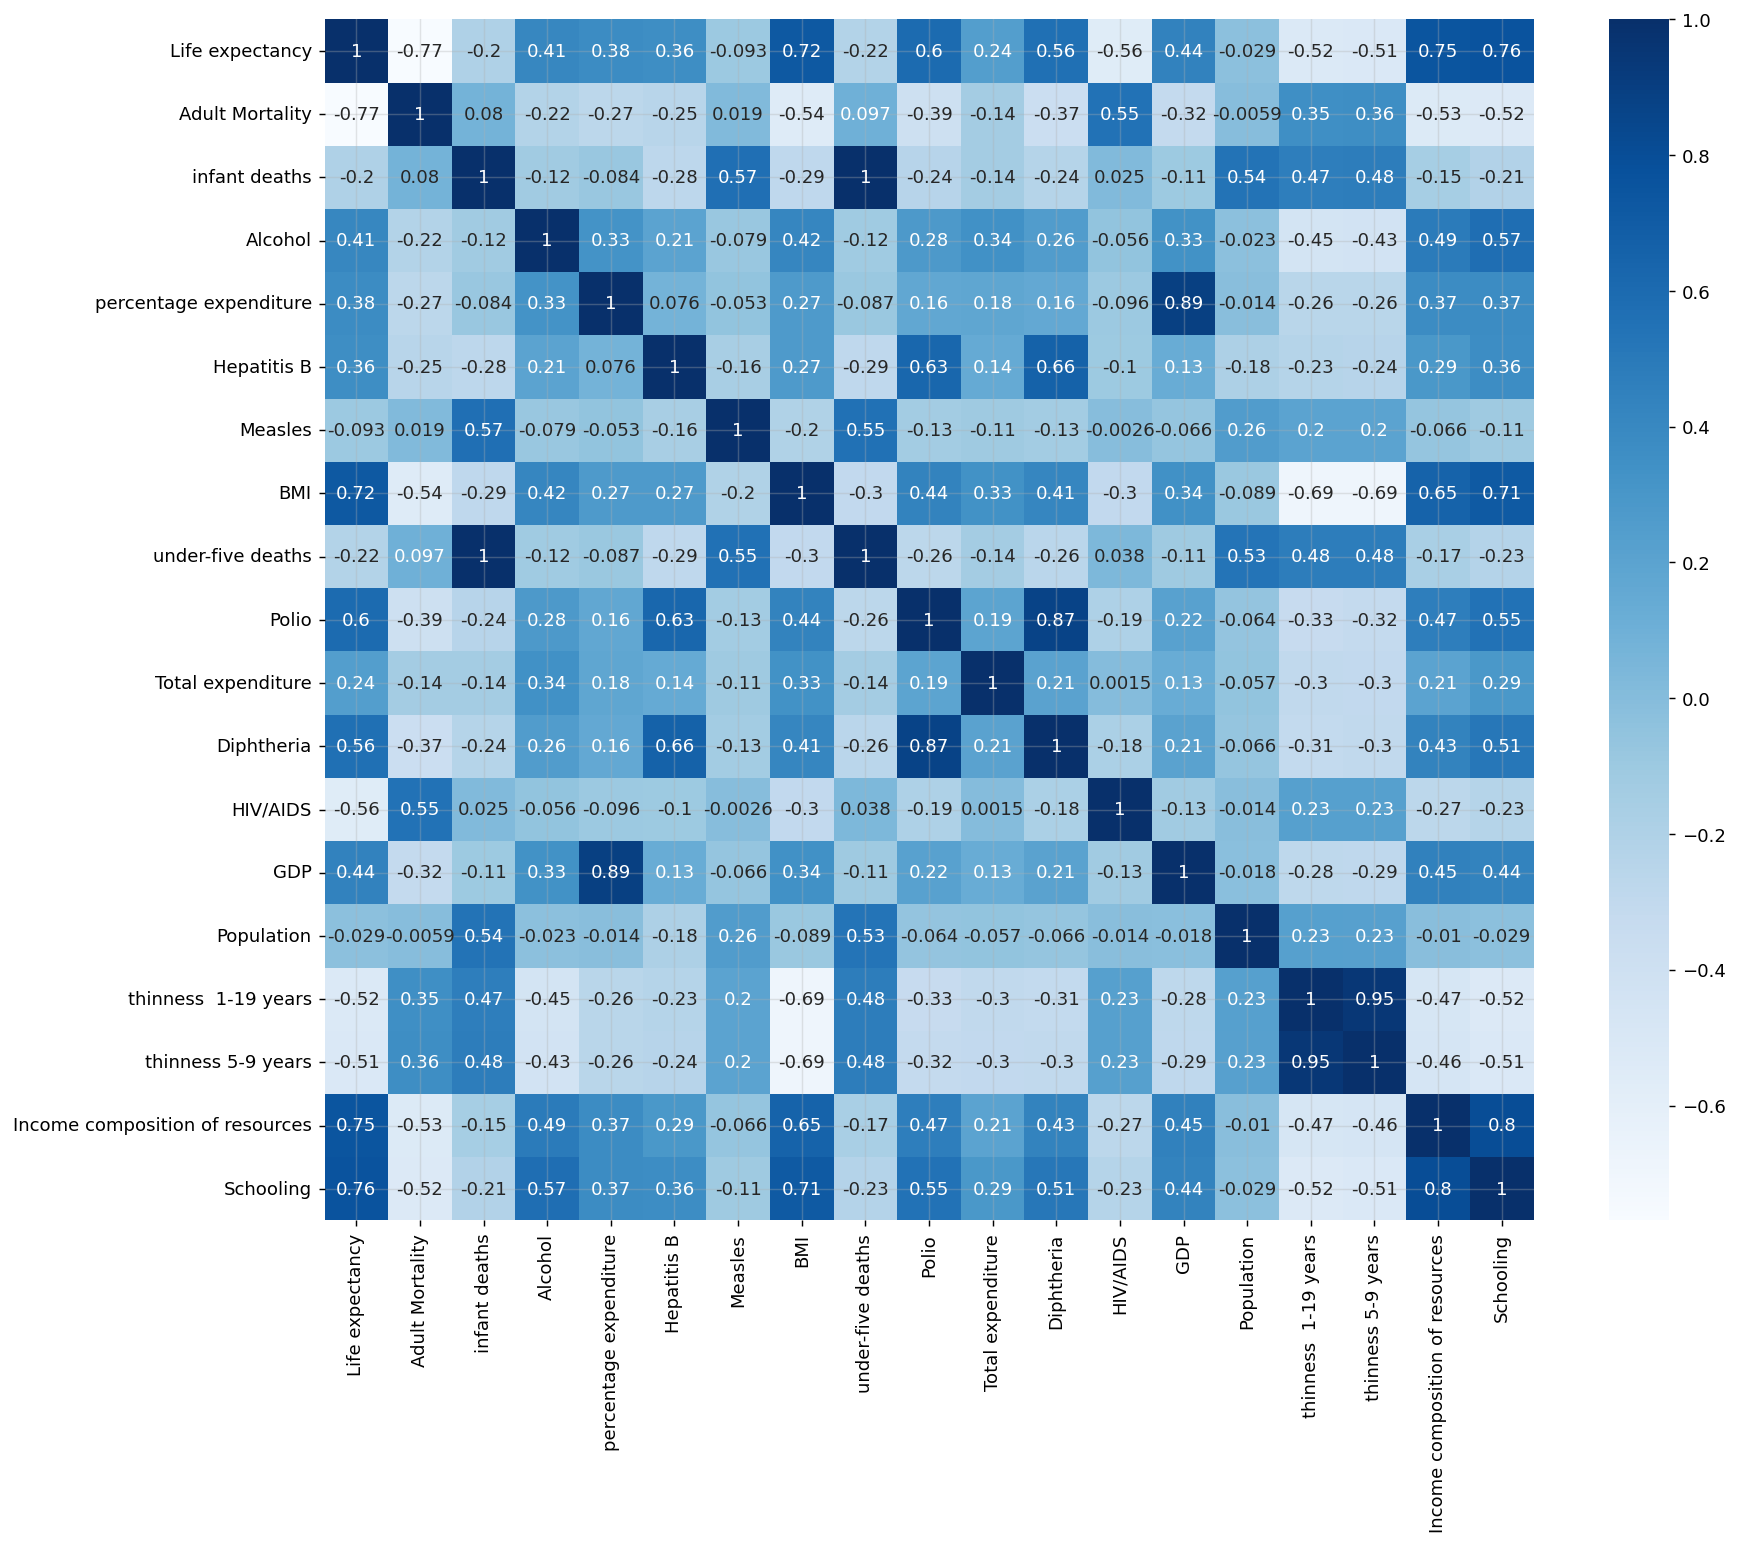

In [169]:
fig, ax = plt.subplots(figsize = (15,12), dpi=130)


heatmap(regression_df[regression_df.columns[3:]].corr(), annot=True, ax=ax, cmap="Blues")

**<h3>**Principal Component Analysis**</h3>**

In [171]:
feature_columns = regression_df.drop('Life expectancy', axis=1).columns[3:]

for column in feature_columns:
    x = regression_df[column]
    regression_df[column] = (x-x.mean())/x.std(ddof=1)

regression_df_features = regression_df[feature_columns]



pca = PCA(n_components = len(regression_df_features.columns))
pca.fit(regression_df_features)
sliced_regression_df_wo_null = pca.transform(regression_df_features)



importance = np.abs(pca.components_) * pca.explained_variance_ratio_.reshape(-1, 1)
feature_importance = importance.sum(axis=0)

for col_name, importance in zip(regression_df.columns[2:], feature_importance):
    print(col_name, '-', importance)

Status - 0.21077115197273708
Life expectancy - 0.181382312800866
Adult Mortality - 0.20054758767570285
infant deaths - 0.1998183608428641
Alcohol - 0.19212623013316674
percentage expenditure - 0.18381792663952778
Hepatitis B - 0.1943241075009938
Measles - 0.18188837152572784
BMI - 0.1892798104531665
under-five deaths - 0.1616858314527183
Polio - 0.1881222028356511
Total expenditure - 0.19202071255760783
Diphtheria - 0.20471437321525474
HIV/AIDS - 0.18063688760182012
GDP - 0.21130907257957343
Population - 0.21103190432661004
thinness  1-19 years - 0.19736047973346538
thinness 5-9 years - 0.1930987861926814


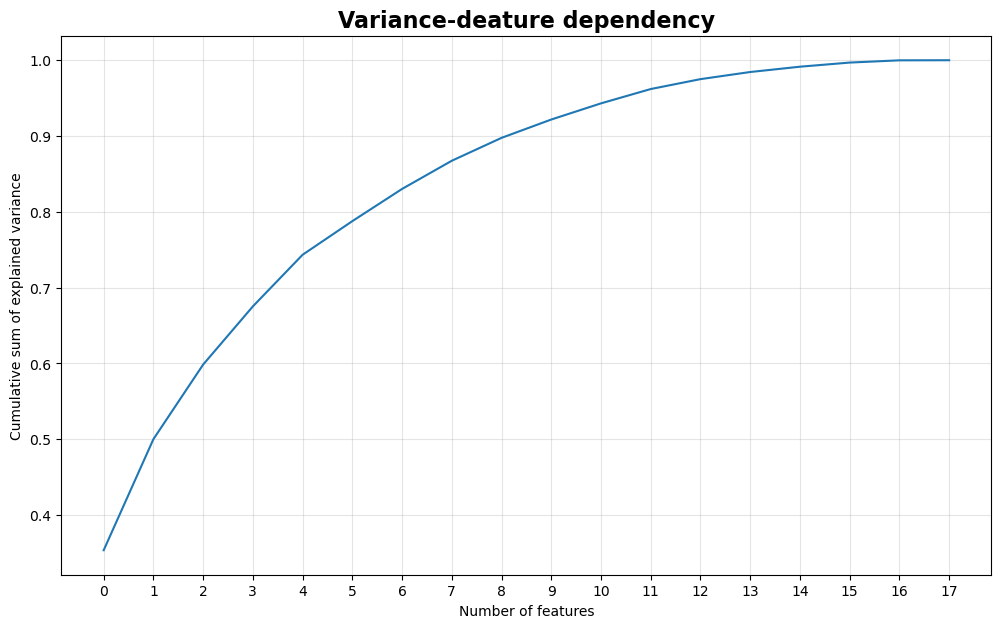

In [172]:
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12,7), dpi=100)
plt.plot(cumsum_variance)
plt.xticks(np.arange(len(regression_df_features.columns)))
plt.ylabel('Cumulative sum of explained variance')
plt.xlabel('Number of features')
plt.title('Variance-deature dependency', fontdict={'fontsize': 16, 'weight': 'bold'})
plt.show()

**<h3>**With the help of correlation matrix and PCA we can say that there are a couple of features that highly correlated with other features, which is not good from statistical point of view, so we're going to remove certain features from the dataset**</h3>**

**<h3>**We also saw that all the features contribte to the target variable relatively the same**</h3>**



In [173]:
regression_df = cleaned_df.copy()
regression_df = regression_df.drop(['Country', 'under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)
num_of_observations_per_year = regression_df.groupby('Year')['Life expectancy'].count()
num_of_observations_per_year

Year
2000    183
2001    183
2002    183
2003    183
2004    183
2005    183
2006    183
2007    183
2008    183
2009    183
2010    183
2011    183
2012    183
2013    193
2014    183
2015    183
Name: Life expectancy, dtype: int64

**<h3>**Since we've done proper cleaning and outliers handling, we have 183 observations per year (except 2013)**<h3>**

In [174]:
# Group DataFrames by years
regression_dfs_by_year = {year: df for year, df in regression_df.groupby('Year')}

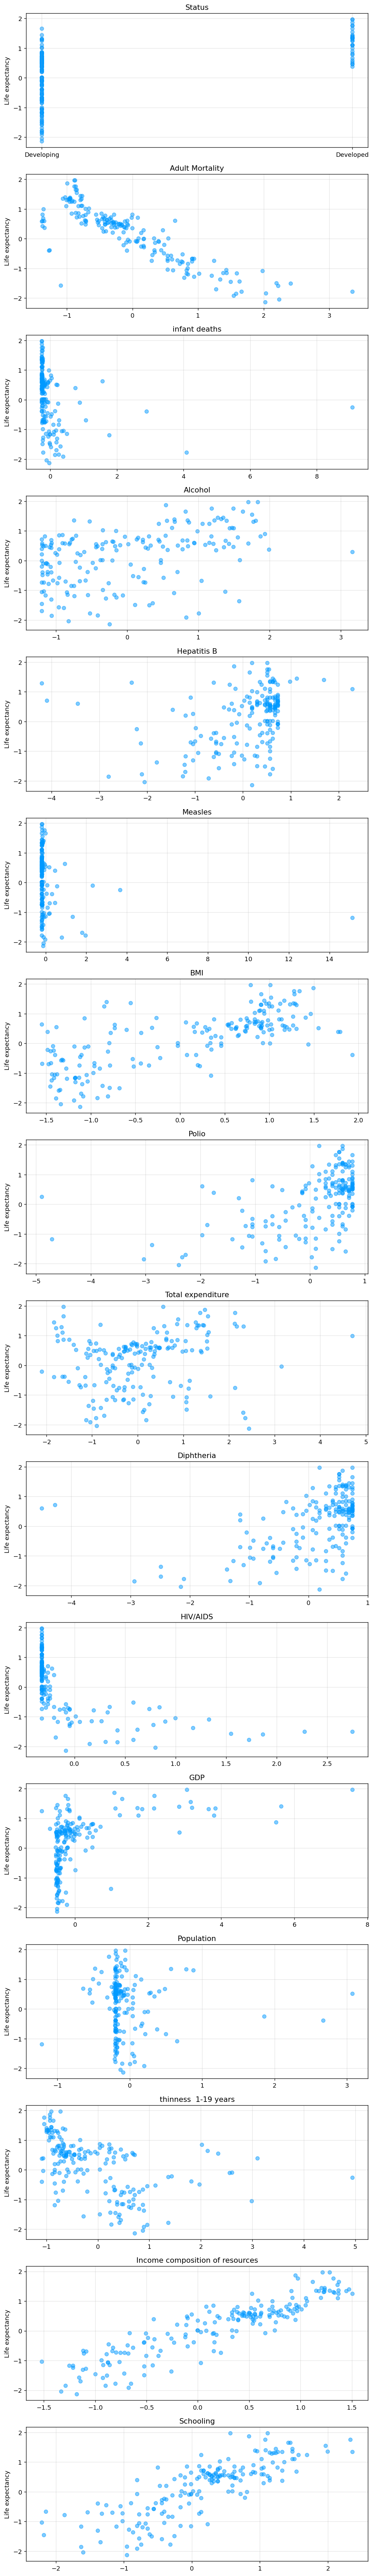

In [175]:
regression_features = regression_df.columns.drop(['Year','Life expectancy'])
fig, axes = plt.subplots(len(regression_features), figsize=(10, 75), dpi=130)

for col_num, col_name in enumerate(regression_features):

    axes[col_num].scatter(regression_dfs_by_year[2011][col_name], regression_dfs_by_year[2011]['Life expectancy'], alpha=0.5, color=(0,0.6,1))
    axes[col_num].set_title(col_name)
    axes[col_num].set_label(col_name)
    axes[col_num].set_ylabel('Life expectancy')



**<h3>**Importing statsmodels' Linear Regression for look at the dependencies:**</h3>**


In [176]:
from statsmodels.api import OLS

linreg_results = {}

for year, df in regression_dfs_by_year.items():
    feature_matrix = df[df.columns[4:]]
    target = df['Life expectancy']

    linreg_statsmodels = OLS(target, feature_matrix).fit()
    linreg_results[year] = linreg_statsmodels



**<h4>**In OLS summary we have coefficients for every feature and corresponding p value which basically inditcates the "probability" of these coefficinets being not statistically significant, so for each year we look at the feature whose coefficients are significant enough (p value < 0.05)**<h4>**

In [177]:
for year in linreg_results.keys():
    print(f"{year}'s relevant feature (corresponding p values) are: \n\n{linreg_results[year].pvalues[linreg_results[year].pvalues<0.05]}")
    print('-'*53)
    print('\n\n\n')

2000's relevant feature (corresponding p values) are: 

BMI                                4.901413e-07
Polio                              1.623380e-04
HIV/AIDS                           2.112063e-21
GDP                                6.679348e-03
Income composition of resources    4.208535e-03
Schooling                          2.723318e-03
dtype: float64
-----------------------------------------------------




2001's relevant feature (corresponding p values) are: 

BMI                                7.032494e-07
HIV/AIDS                           8.160776e-24
GDP                                3.413966e-04
Income composition of resources    1.445734e-02
Schooling                          4.331557e-03
dtype: float64
-----------------------------------------------------




2002's relevant feature (corresponding p values) are: 

BMI                                2.457403e-05
Diphtheria                         3.944327e-02
HIV/AIDS                           7.400795e-26
GDP           

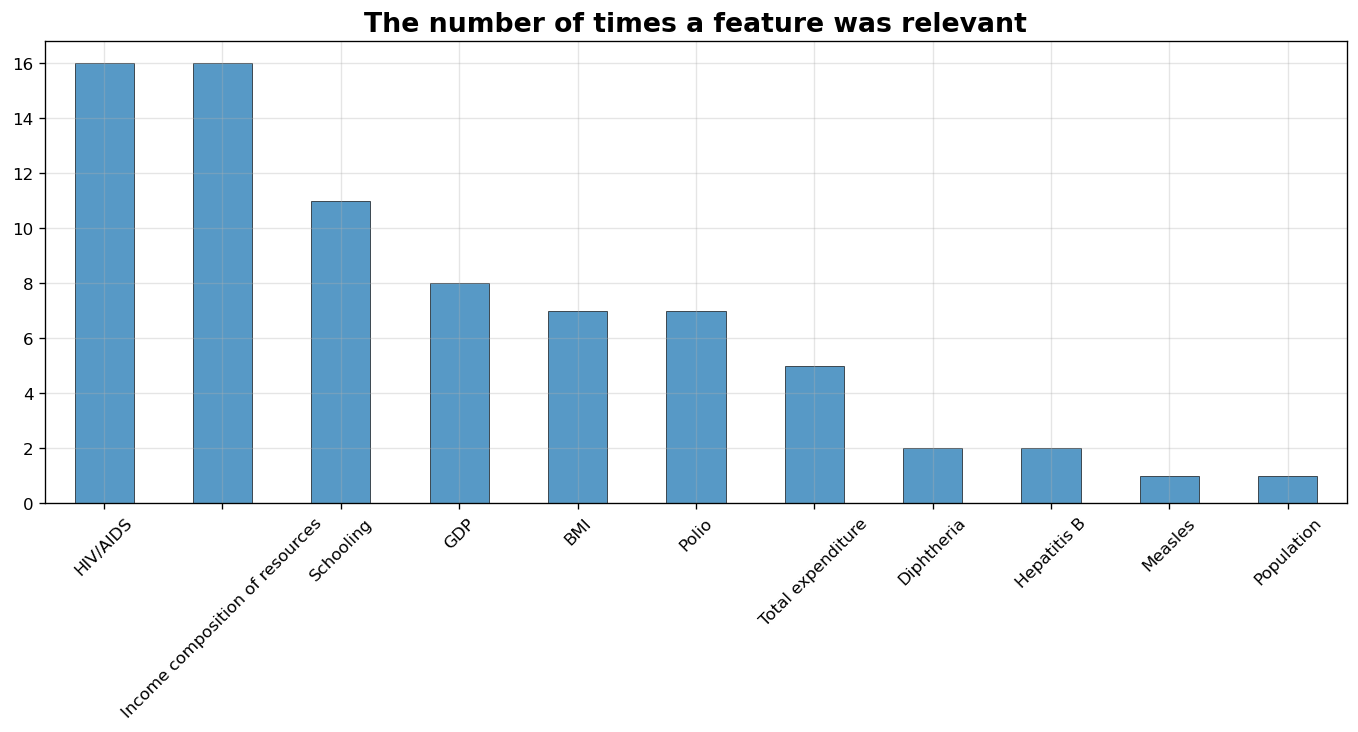

In [178]:
most_important_features = {}

for year in linreg_results.keys():
    important_features_per_year = linreg_results[year].pvalues[linreg_results[year].pvalues<0.05].index

    for important_feature in important_features_per_year:
        if important_feature in most_important_features.keys():
            most_important_features[important_feature]+=1
        else:
            most_important_features[important_feature]=1


fig, ax = plt.subplots(figsize = (14,5), dpi=120)

pd.Series(most_important_features).sort_values(ascending=False).plot(kind="bar", ax=ax, edgecolor="black",linewidth=0.5, alpha=0.75)
plt.xticks(rotation=45)
plt.title("The number of times a feature was relevant", fontdict={"weight": "bold", "size": 16})
plt.show()

**<h2>**Multivariate Time Series Analysis**</h2>**

<br><br>
**<h4>**As 'Status' column is not informationally significant to our time serieses because it is a basically a constant we can drop this column**<h4>**

In [179]:
tsa_df = cleaned_df.copy()
tsa_df = tsa_df.sort_values(by=['Country', 'Year'])
# tsa_df = tsa_df.drop('Status', axis=1)
tsa_df = tsa_df.drop(['under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)

num_of_observations_per_country = tsa_df.groupby('Country')['Life expectancy'].count()
relevant_countries = num_of_observations_per_country[num_of_observations_per_country.sort_values(ascending=True)>10]
irrelevant_countries = num_of_observations_per_country[num_of_observations_per_country.sort_values(ascending=True)<10]


In [180]:
irrelevant_countries_index = tsa_df[tsa_df['Country'].apply(lambda x: True if x in irrelevant_countries else False)].index

tsa_df = tsa_df.drop(irrelevant_countries_index, axis=0)
tsa_df = tsa_df.reset_index(drop=True)

In [181]:
tsa_dfs_by_country = {country: df for country, df in tsa_df.groupby('Country')}
feature_columns = tsa_df.columns.drop(['Country', 'Year', 'Life expectancy'])
target_column = 'Life expectancy'


In [182]:
from scipy.stats import yeojohnson

def check_stationarity(time_series: pd.Series) -> tuple[str, str]:

    adf_p_value = adfuller(time_series)[1]
    kpss_p_value = kpss(time_series, nlags='auto')[1]
    
    adf_result = "Stationary" if adf_p_value < 0.05 else "Not stationary"
    kpss_result = "Not stationary" if kpss_p_value < 0.05 else "Stationary"
    
    return adf_result, kpss_result

def make_stationary(time_series: pd.Series) -> pd.Series:

    """
    NOTE:
    Some of the columns might contain cxonstant values,
    and kpss test returns an error if an input is just a series of 
    constant values, thus here we test if the time series is constant.
    """
    if time_series.max() == time_series.min():
        return time_series


    adf_result, kpss_result = check_stationarity(time_series)
    
    if adf_result == "Stationary" and kpss_result == "Stationary":
        return time_series
    
    elif adf_result == "Not stationary" and kpss_result == "Stationary":
        # Применяем преобразование Yeo-Johnson
        time_series = yeojohnson(time_series)[0]
        time_series = pd.Series(time_series)
    
    elif adf_result == "Stationary" and kpss_result == "Not stationary":
        # Берем первую разность
        time_series = time_series.diff().dropna()

        adf_result, kpss_result = check_stationarity(time_series)

        if kpss_result == "Not stationary":

            time_series = time_series.diff().dropna()

    
    # Повторная проверка
    adf_result, kpss_result = check_stationarity(time_series)
    
    if adf_result == "Not stationary" or kpss_result == "Not stationary":
        return "Cannot be made stationary"
    
    return time_series



    

In [183]:
non_stationary_ts_per_country = {}
non_stationary_count = 0



for keys, values in tsa_dfs_by_country.items():
    
    country_df = values[feature_columns]
    non_stationary_count = 0

    for column in country_df.columns:
        if type(make_stationary(country_df[column])) == str:
            non_stationary_count+=1

    non_stationary_ts_per_country[keys] = non_stationary_count

        



C:\Users\user\AppData\Local\Temp\ipykernel_28544\3081248242.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(time_series, nlags='auto')[1]
C:\Users\user\AppData\Local\Temp\ipykernel_28544\3081248242.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(time_series, nlags='auto')[1]
C:\Users\user\AppData\Local\Temp\ipykernel_28544\3081248242.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(time_series, nlags='auto')[1]
C:\Users\user\AppData\Local\Temp\ipykernel_28544\3081248242.py:6: InterpolationWarning: The test statistic is outside of the range of p-values av

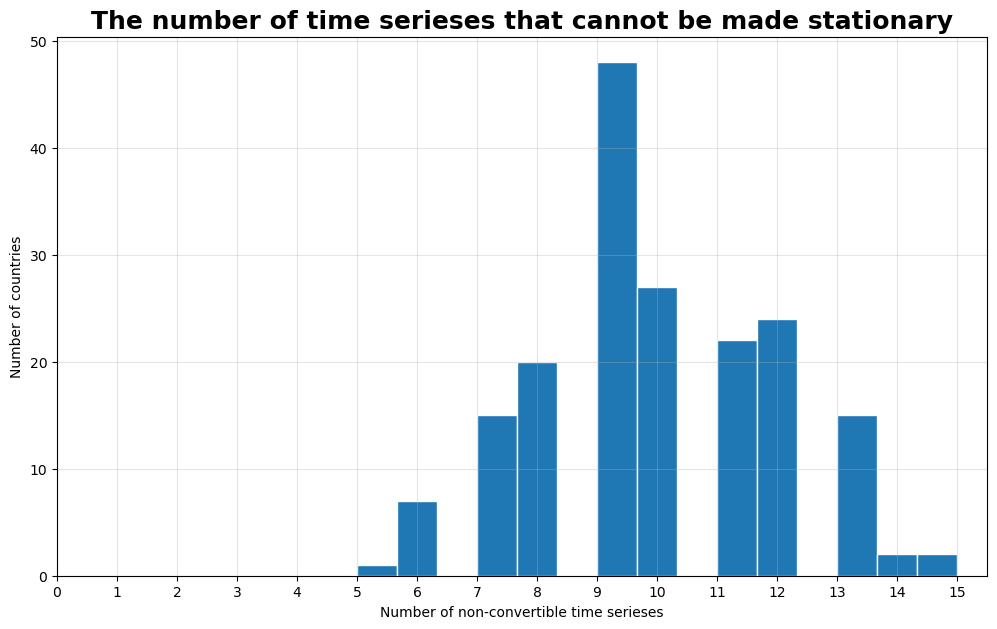

In [184]:
non_stationary_ts_per_country = pd.Series(non_stationary_ts_per_country)
non_stationary_ts_per_country.hist(figsize=(12,7), edgecolor='white', bins=15)
plt.xticks(np.arange(16))
plt.title("The number of time serieses that cannot be made stationary", fontdict={"size": 18, "weight": "bold"})
plt.xlabel("Number of non-convertible time serieses")
plt.ylabel("Number of countries")
plt.show()

**<h4>**As we can see, there is on average a significant amount of time series that cannot be made stationary through traditional methods. Thus, VARIMA model wouldn't be the best choice in that case.<br><br>Instead boosting alorithms are going to be used as they appear to be more robust to outliers and other preventive factors in our dataset**<h4>**

In [185]:
status_feature_count = {}

for country in tsa_dfs_by_country.keys():

    if len(tsa_dfs_by_country[country]['Status'].value_counts())>1:
        status_feature_count[country] = len(tsa_dfs_by_country[country]['Status'].value_counts())


status_feature_count


{}

**<h4>**We see that for each country 'Status' column is not informationally significant as it is just a constant value, so we can easily drop it from the TS dataset**<h4>**

In [186]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

def create_features(df: pd.DataFrame, target_column, lags: int) -> pd.DataFrame:
    """
    Create lag feature as we assume that the previous values of TS 
    have certain impact on y_t
    """

    df = df.copy()
    df = df.drop(['Country', 'Status', 'Year'], axis=1)

    for lag in range(lags):

        df[f"lag_{lag+1}"] = df[target_column].shift(lag+1)

    df.dropna(inplace=True)

    return df

def train_xgboost_for_country(df, target_column):

    df = create_features(df, target_column, lags=3)
    
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Create "cross-validation" for Time Series
    tscv = TimeSeriesSplit(n_splits=3)
    model = XGBRegressor(n_estimators=100, learning_rate=0.1)


    # Create place holders for choosing the best model
    best_model: XGBRegressor
    best_score = float('inf')

    # Choose best model based on perfomance
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        score = mean_absolute_percentage_error(y_test, model.predict(X_test))  # Evaluate
    
        if score < best_score:  # Keep the best model
            best_model = model
            best_score = score


    return best_model, best_score

def train_xgboost_for_all_countries(data_dict, target_column):

    results = {}
    for country, df in data_dict.items():

        model, mape = train_xgboost_for_country(df, target_column)

        results[country] = {
            "model": model, 
            "mape": mape
            }

        print(f"{country}: \nMAPE = {mape}\n")
    return results


In [187]:
results = train_xgboost_for_all_countries(tsa_dfs_by_country, target_column=target_column)


Afghanistan: 
MAPE = 0.05839799766954338

Albania: 
MAPE = 0.09845322102989022

Algeria: 
MAPE = 0.16017928099002132

Angola: 
MAPE = 0.04786184555246172

Antigua and Barbuda: 
MAPE = 0.06210912140506339

Argentina: 
MAPE = 0.04009016461984226

Armenia: 
MAPE = 0.08303419108620406

Australia: 
MAPE = 0.018930479278983742

Austria: 
MAPE = 0.18695200372997123

Azerbaijan: 
MAPE = 0.6495485752131288

Bahamas: 
MAPE = 0.06598991221652416

Bahrain: 
MAPE = 0.043475850899135755

Bangladesh: 
MAPE = 0.8695732900748435

Barbados: 
MAPE = 0.05415300313442053

Belarus: 
MAPE = 0.41872682859598337

Belgium: 
MAPE = 0.02011847083607071

Belize: 
MAPE = 0.12142406987509714

Benin: 
MAPE = 0.0557605543406541

Bhutan: 
MAPE = 0.5625288972638841

Bolivia (Plurinational State of): 
MAPE = 0.8024043465474279

Bosnia and Herzegovina: 
MAPE = 0.047646148240834595

Botswana: 
MAPE = 0.2824149874446957

Brazil: 
MAPE = 0.06113567851271565

Brunei Darussalam: 
MAPE = 0.08591790610300154

Bulgaria: 
MAPE = 0

**<h4>**Now we have a dictionary with the model and most relevant metrics. From here you can choose the model (for a country) and try to "predict" future :)**<h4>**

In [188]:
Zimbabwe_features_df = tsa_dfs_by_country['Zimbabwe']
results['Zimbabwe']['model'].predict(create_features(Zimbabwe_features_df, target_column=target_column, lags=3).drop(target_column, axis=1))

array([-2.5957806, -2.6151154, -2.5854144, -2.501482 , -2.3755727,
       -2.2076166, -2.0187397, -1.7674208, -1.5049924, -1.3304489,
       -1.3304489, -1.3304489, -1.3304489], dtype=float32)